# Libraies

In [ ]:
# Import Necessary Libaries
%matplotlib inline
import os
import sys
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Pre-Defined Parameters
This is where we can define some model pramaters before we begin training.

In [ ]:
# Customize Training Parameters Here
# https://pytorch.org/docs/stable/nn.html for all param info
CLIP = 3
RNN_TYPE = "gru"
DROPOUT = "normal"
DROPOUT_RATE = .5
OPTIMIZER_TYPE = "adam"
criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss().cuda()
criterion_test = nn.CrossEntropyLoss().cuda()

# Customize Outout MIDI File Here 
SAMPLE_LENGTH = 400
TEMPERATURE = .8 
DT = .2

# DataLoader

This Section of code is responsible for converting the .midi files to a numeric representation.
Code Taken Directly from https://github.com/jmcarpenter2/music-generation

In [ ]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Pressed notes are replaced by 1
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
        
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll

    return padded_piano_roll


class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # Shifting by one time step
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifting by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # padding sequence so that all of them have the same length
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,max_length=self.longest_sequence_length,pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),torch.LongTensor(ground_truth_sequence_padded),torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [ ]:
# Load Training Data
trainset = NotesGenerationDataset('./Kanye/train/', longest_sequence_length=None)
trainset_loader = data.DataLoader(trainset, batch_size=8,shuffle=True, drop_last=True)

# Get Training Data Shape
X = next(iter(trainset_loader))
print("Train Size:",X[0].shape)
print()

# Load Validation Set
valset = NotesGenerationDataset('./Kanye/valid/', longest_sequence_length=None)
valset_loader = data.DataLoader(valset, batch_size=8, shuffle=False, drop_last=False)

# Get Validation Set Size
X_val = next(iter(valset_loader))
print("Validation Size:",X_val[0].shape)
print()

# Load Test Set
testset = NotesGenerationDataset('./Kanye/test/', longest_sequence_length=None)
testset_loader = data.DataLoader(testset, batch_size=8, shuffle=False, drop_last=False)

# Get Test Set Size
X_test = next(iter(testset_loader))
print("Test Size:",X_test[0].shape)
print()

# Load Full Data Set
fulldata = NotesGenerationDataset('./Kanye/full_data/', longest_sequence_length=None)
full_data_loader = data.DataLoader(fulldata, batch_size=8, shuffle=False, drop_last=False)

Train Size: torch.Size([8, 2643, 88])

Validation Size: torch.Size([8, 2643, 88])

Test Size: torch.Size([8, 1842, 88])



# RNN
Here we build our RNN. 

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        

        # Linear Layer
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        # Batch Normalization
        self.bn = nn.BatchNorm1d(hidden_size)

        # RNN (GRU or LSTM)
        if RNN_TYPE == "lstm":
          self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        else:
          self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)

        # Linear Layer
        self.logits_fc = nn.Linear(hidden_size, num_classes)

        
        # Dropout (Alpha or Regular)
        if DROPOUT == "alpha":
          self.dropout = nn.AlphaDropout(DROPOUT_RATE)
        else:
          self.dropout = nn.Dropout(DROPOUT_RATE)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        
        # Change Axis
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        
        # Batch Normalization
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        # Dropout
        notes_encoded_norm_drop = self.dropout(notes_encoded_norm)
        
        # Return to axis
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        
        # RNN
        outputs, hidden = self.rnn(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        # Batch Normalization
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        
        # Dropout
        outputs_drop = self.dropout(outputs_norm)
        
        # Linear Layer
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

# Parameter Search
This is where we try out different parameters. We loop through different hidden layer values, epochs, and learning rates and use the validation set as the way to determine what parameters gave us the best results using Cross Entropy Loss. We also save the optimal model that gave us the best validation loss.

In [ ]:
# Test the model on the validation set
def validate(model):
    
    # Set to evaluate mode
    model.eval()

    # Keep a track of the loss
    full_val_loss = 0.0
    overall_sequence_length = 0.0


    # Loop through the batches
    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [ ]:
# Function that determines what parameters we should be using.
def lrfinder(start, end, trainset_loader):
    
    # Different Hidden Values
    hiddens = [16, 32, 64 ,128, 256, 512]
    
    # Different Learning Rates
    learning_rates = np.linspace(start, end, 4)
    
    # Max Epochs to test out
    epochs = 20


    # Used to let us know how far along this cell will take
    denom = (epochs)*len(hiddens)*len(learning_rates)


    # Initialize all parameters 
    best_epoch = 0
    best_hidden = 0
    best_lr = 0
    best_val_loss = float("inf")
    train_loss = float("inf")
    counter = 0
    
    # Loop through different learning rates and hidden layers
    for hidden in hiddens:
      for rate in learning_rates:
        
        # Let the user know how much percent this cell is complete
        print("Percent Complete: {}%".format((counter / denom) * 100))
        
        # Create the Model and set to training mode
        model = RNN(input_size=88, hidden_size=hidden, num_classes=88)
        model = model.cuda()
        model.train()
        
        parameters = filter(lambda p: p.requires_grad, model.parameters())
        
        # Pick the Optimzier the user defines
        if OPTIMIZER_TYPE == "sgd":
          optimizer = torch.optim.SGD(model.parameters(), lr=rate)
        else:
          optimizer = torch.optim.Adam(model.parameters(), lr=rate)

        # Loop through the epochs (20 in this case)
        for i in range(epochs):
          model.train()
          
          # Keep a track of the loss per epoch
          epoch_loss = [] 
          
          # Loop through the batches
          for batch in trainset_loader:
            
            post_processed_batch_tuple = post_process_sequence_batch(batch)
            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            # Get the Loss
            loss = criterion(logits, output_sequences_batch_var)
            epoch_loss.append(loss.item())
   

            loss.backward()

            # Clip the Gradients 
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)

            optimizer.step()
            
          # Add to our completion percentage   
          counter = counter + 1
          
          
          # Get the validation after one pass through of the data
          val_loss = validate(model)
          
          # If the validation loss is better, update the params and save the model
          if val_loss < best_val_loss:
            best_epoch = i
            best_hidden = hidden
            best_lr = rate
            best_val_loss = val_loss
            train_loss = sum(epoch_loss)/len(trainset_loader)
            
            # Save the model for the next step
            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')



    # Return the params that gave the optimal loss
    return best_epoch, best_hidden, best_lr, best_val_loss, train_loss
            

In [ ]:
# Find the best params and save the results and model
best_epoch, best_hidden_size, best_learning_rate, val_loss, train_loss = lrfinder(1e-4, 1e-1*5,trainset_loader)
print("Best Epoch:",best_epoch, "  Best Hidden Size:",best_hidden_size, "  Best Learning Rate:",best_learning_rate) 

Percent Complete: 0.0%
Percent Complete: 4.166666666666666%
Percent Complete: 8.333333333333332%
Percent Complete: 12.5%
Percent Complete: 16.666666666666664%
Percent Complete: 20.833333333333336%
Percent Complete: 25.0%
Percent Complete: 29.166666666666668%
Percent Complete: 33.33333333333333%
Percent Complete: 37.5%
Percent Complete: 41.66666666666667%
Percent Complete: 45.83333333333333%
Percent Complete: 50.0%
Percent Complete: 54.166666666666664%
Percent Complete: 58.333333333333336%
Percent Complete: 62.5%
Percent Complete: 66.66666666666666%
Percent Complete: 70.83333333333334%
Percent Complete: 75.0%
Percent Complete: 79.16666666666666%
Percent Complete: 83.33333333333334%
Percent Complete: 87.5%
Percent Complete: 91.66666666666666%
Percent Complete: 95.83333333333334%
Best Epoch: 13   Best Hidden Size: 16   Best Learning Rate: 0.16673333333333332


## Test Set
With our optimal model, we check to see how this model does on the test set. If the test loss isn't too much higher than the validation loss, we continue. 

In [ ]:
# Load the optimal model we created from the previous step
test_model = RNN(input_size=88, hidden_size=best_hidden_size, num_classes=88)
test_model = test_model.cuda()
test_model.load_state_dict(torch.load('music_model_padfront_regularized.pth'))
test_model.eval()

# Initilize the Test Loss
full_test_loss = 0.0
overall_sequence_length = 0.0

# Loop through the batches
for batch in testset_loader:

    post_processed_batch_tuple = post_process_sequence_batch(batch)

    input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

    output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

    input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

    logits, _ = test_model(input_sequences_batch_var, sequences_lengths)

    loss = criterion_test(logits, output_sequences_batch_var)

    full_test_loss += loss.item()
    overall_sequence_length += sum(sequences_lengths)

# Show the Validation and Test Loss of this model
print("Validation Loss", val_loss)
print("Test Loss", full_test_loss / (overall_sequence_length * 88))    

Validation Loss 6.622388702578636e-07
Test Loss 8.733955039356646e-07


## Model Training
Now that we know what parameters to use, we build the model using the optimal parameters on the entire dataset (train, valid, test).

In [ ]:
def train_model(learning_rate, epochs_number, hidden):
    model = RNN(input_size=88, hidden_size=hidden, num_classes=88)
    model = model.cuda()
    model.train()
    
    
    # Determine which Optimzier to use 
    if OPTIMIZER_TYPE == "sgd":
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    else:
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    

    # Loop through different Epoch values    
    for epoch_number in range(epochs_number):
        
        model.train()
        
        # Loop through different Learning rates 
        for batch in full_data_loader:
            post_processed_batch_tuple = post_process_sequence_batch(batch)
            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
            optimizer.zero_grad()
            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            # Get Loss
            loss = criterion(logits, output_sequences_batch_var)
            loss.backward()

            # Clip Gradient
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)

            optimizer.step()

    torch.save(model.state_dict(), 'final_model.pth')

In [ ]:
train_model(best_learning_rate, best_epoch, best_hidden_size)

# Music Generation
Now that we have finished training our RNN, we can now use it to generate music! The generated clip will be in this working directory.

In [ ]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):

    # Arbitrary Starting Point
    if starting_sequence is None:

        # Initialize the current sequence         
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    
    # If we have a given starting point
    else:
        current_sequence_input = starting_sequence
        
    # Create the output sequence 
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    # Sample For the desired length 
    for i in range(sample_length):

        # Use the current sequence to generate a new sequence 
        output, hidden = rnn(current_sequence_input, [1], hidden)

        # Get the probabilites of possible notes from the output and temperature
        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        # Sample from the multinomial distribution and set this new sequence to be current sequence 
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        # Returns tensor 
        current_sequence_input = Variable(current_sequence_input.float())

        # Append this current sequence to our entire output
        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    
    # Finalize the Output and return
    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

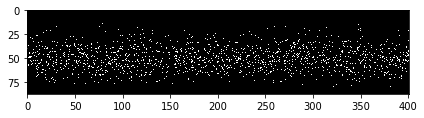

In [ ]:
final_model = RNN(input_size=88, hidden_size=best_hidden_size, num_classes=88)
final_model = final_model.cuda()
final_model.load_state_dict(torch.load('final_model.pth'))
final_model.eval()
sample = sample_from_piano_rnn(final_model, sample_length=SAMPLE_LENGTH, temperature=TEMPERATURE,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite(RNN_TYPE+" Clip:"+str(CLIP)+" Epochs:"+str(best_epoch)+" Optimizer:"+OPTIMIZER_TYPE+" Hidden:"+str(best_hidden_size)+" Dropout:"+str(DROPOUT)+" Dropout Rate:"+str(DROPOUT_RATE)+" Length:"+str(SAMPLE_LENGTH)+" Temperature:"+str(TEMPERATURE)+" DT:"+str(DT)+".mid", sample.transpose(), dt=DT)